# Traffic Sign Classification
Using CNN & Resnet pretrained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import yaml
with open('/content/data.yaml') as f:
    dict = yaml.safe_load(f)
    print(dict)

[{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 48, 'names': ['All Motor Vehicle Prohibited', 'Barrier Ahead', 'Bullock And Handcart Prohibited', 'Compulsary Ahead', 'Compulsary Keep Left', 'Compulsary Keep Right', 'Compulsary Sound Horn', 'Compulsary Turn Left', 'Compulsary Turn Right', 'Cross Road', 'Cycle Prohibited', 'Give Way', 'Horse Car Prohibited', 'Left Hand Curve', 'Left Reverse Bend', 'Left Turn Prohibited', 'Major Road Ahead', 'Men At Work', 'Narrow Bridge', 'Narrow Road Ahead', 'Narrow Road Left Ahead', 'No Entry', 'No Heavy Vehicles', 'No Parking', 'No Stopping', 'Pedestrian Crossing', 'Pedestrian Prohibited', 'Right Hair Pin Bend', 'Right Hand Curve', 'Right Reverse Bend', 'Right Turn', 'Right Turn Prohibited', 'Road Wideness Ahead', 'Roundabout', 'School Ahead', 'Side Road', 'Slippery Road', 'Sound Horn', 'Speed Limit', 'Steep Ascent', 'Stop', 'Straight Prohibited', 'T Junction', 'Traffic  Signal', 'Two Way Signs', 'U Turn Prohibi

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
class TrafficSignDataset(Dataset):
    def __init__(self, dataset, type, transform=None):
        self.images_dir = os.path.join(dataset, type, "images")
        self.labels_dir = os.path.join(dataset, type, "labels")
        self.transform = transform

        self.image_filenames = sorted([f for f in os.listdir(self.images_dir) if f.endswith(('.jpg', '.png'))])
        self.label_filenames = sorted([f for f in os.listdir(self.labels_dir) if f.endswith('.txt')])

        # Filter out images with empty or invalid label files
        valid_pairs = []
        for img_file, label_file in zip(self.image_filenames, self.label_filenames):
            label_path = os.path.join(self.labels_dir, label_file)
            try:
                with open(label_path, 'r') as f:
                    line = f.readline().strip()
                    if line:  # Ensure the label file is not empty
                        int(line.split()[0])  # Ensure the first value is valid
                        valid_pairs.append((img_file, label_file))
            except Exception as e:
                print(f"Skipping invalid label file '{label_file}': {e}")

        self.image_filenames, self.label_filenames = zip(*valid_pairs) if valid_pairs else ([], [])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
        image = Image.open(img_path).convert("RGB")

        with open(label_path, 'r') as f:
            class_id = int(f.readline().split()[0])  # Only the first line and first value

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(class_id, dtype=torch.long)

In [ ]:
# Define image transformations (resize, normalize, etc.)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Define paths and loaders
base_directory = "/content/drive/MyDrive/dataset_roboflow"
train_dataset = TrafficSignDataset(dataset=base_directory, type="train", transform=data_transforms)
test_dataset = TrafficSignDataset(dataset=base_directory, type="test", transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
class TrafficSignClassifierCNN(nn.Module):
    def __init__(self, num_classes, input_size=(3, 224, 224)):
        super(TrafficSignClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: (32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: (64, 28, 28)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: (128, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Output: (128, 14, 14)
        )

        # Dynamically compute the flattened size
        self.feature_map_size = self._get_flattened_size(input_size)

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_map_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _get_flattened_size(self, input_size):
        """Compute the size of the flattened feature map after the convolutional layers."""
        dummy_input = torch.zeros(1, *input_size)  # Batch size of 1
        dummy_output = self.conv_layers(dummy_input)
        return int(torch.prod(torch.tensor(dummy_output.shape[1:])))  # Compute flattened size

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")
    print("GPU is not available.")

# Initialize model, criterion, and optimizer
num_classes = 48


GPU is available!


In [ ]:
modelCNN = TrafficSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
modelResnet = TrafficSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelResnet.parameters(), lr=0.001)

#CNN Model

In [ ]:
import matplotlib.pyplot as plt

def train_model_CNN(modelCNN, train_loader, criterion, optimizer, epochs=10):
    modelCNN = modelCNN.to(device)
    modelCNN.train()

    # Lists to store loss and accuracy for each epoch
    epoch_losses_cnn = []
    epoch_accuracies_cnn = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, class_ids in train_loader:
            images, class_ids = images.to(device), class_ids.to(device)

            optimizer.zero_grad()
            outputs = modelCNN(images)  # Forward pass
            loss = criterion(outputs, class_ids)  # Compute loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted classes
            total += class_ids.size(0)  # Total number of samples
            correct += predicted.eq(class_ids).sum().item()  # Correct predictions

        # Calculate epoch loss and accuracy
        epoch_loss_cnn = total_loss / len(train_loader)
        epoch_accuracy_cnn = 100.0 * correct / total

        epoch_losses_cnn.append(epoch_loss_cnn)
        epoch_accuracies_cnn.append(epoch_accuracy_cnn)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss_cnn:.4f}, Accuracy: {epoch_accuracy_cnn:.2f}%")

    return epoch_losses_cnn, epoch_accuracies_cnn


In [ ]:
epoch_losses_cnn, epoch_accuracies_cnn = train_model_CNN(modelCNN, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 1.0900, Accuracy: 69.85%
Epoch 2/10, Loss: 0.5065, Accuracy: 84.37%
Epoch 3/10, Loss: 0.3213, Accuracy: 90.17%
Epoch 4/10, Loss: 0.2093, Accuracy: 93.36%
Epoch 5/10, Loss: 0.1510, Accuracy: 95.10%
Epoch 6/10, Loss: 0.1260, Accuracy: 95.74%
Epoch 7/10, Loss: 0.0968, Accuracy: 97.04%
Epoch 8/10, Loss: 0.1187, Accuracy: 96.32%
Epoch 9/10, Loss: 0.0910, Accuracy: 97.11%
Epoch 10/10, Loss: 0.0379, Accuracy: 98.81%


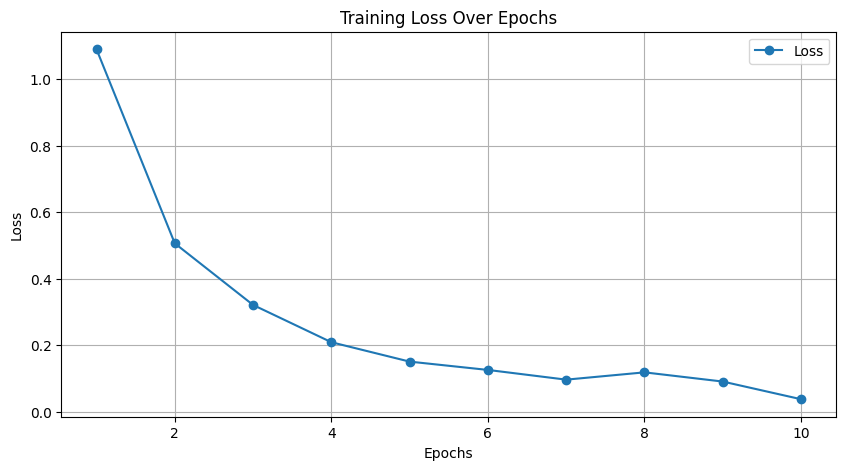

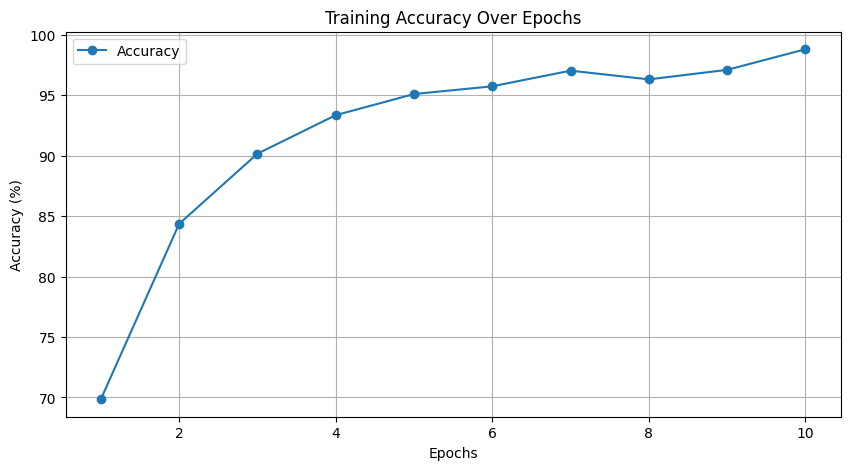

In [ ]:
# Train the model and log loss and accuracy


# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses_cnn) + 1), epoch_losses_cnn, marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.legend()
plt.show()

# Plot the accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_accuracies_cnn) + 1), epoch_accuracies_cnn, marker='o', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# Testing function
def test_modelCNN(modelCNN, test_loader):
    modelCNN.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, class_ids in test_loader:
            images, class_ids = images.to(device), class_ids.to(device)
            outputs = modelCNN(images)
            _, predicted = outputs.max(1)
            total += class_ids.size(0)
            correct += predicted.eq(class_ids).sum().item()

    print(f"Test Accuracy: {100. * correct / total:.2f}%")

# Train and test the model


In [ ]:
test_modelCNN(modelCNN, test_loader)

Test Accuracy: 77.02%


#ResNet Pre-trained Model

In [ ]:
import matplotlib.pyplot as plt

def train_model_resnet(modelResnet, train_loader, criterion, optimizer, epochs=10):
    modelResnet = modelResnet.to(device)
    modelResnet.train()

    # Lists to store loss and accuracy for each epoch
    epoch_losses_res = []
    epoch_accuracies_res = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, class_ids in train_loader:
            images, class_ids = images.to(device), class_ids.to(device)

            optimizer.zero_grad()
            outputs = modelResnet(images)  # Forward pass
            loss = criterion(outputs, class_ids)  # Compute loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted classes
            total += class_ids.size(0)  # Total number of samples
            correct += predicted.eq(class_ids).sum().item()  # Correct predictions

        # Calculate epoch loss and accuracy
        epoch_loss_res = total_loss / len(train_loader)
        epoch_accuracy_res = 100.0 * correct / total

        epoch_losses_res.append(epoch_loss_res)
        epoch_accuracies_res.append(epoch_accuracy_res)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss_res:.4f}, Accuracy: {epoch_accuracy_res:.2f}%")

    return epoch_losses_res, epoch_accuracies_res


In [ ]:
train_model_resnet(modelResnet, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 1.1136, Accuracy: 68.65%
Epoch 2/10, Loss: 0.5153, Accuracy: 84.15%
Epoch 3/10, Loss: 0.3327, Accuracy: 89.92%
Epoch 4/10, Loss: 0.2185, Accuracy: 93.44%
Epoch 5/10, Loss: 0.1679, Accuracy: 94.68%
Epoch 6/10, Loss: 0.1217, Accuracy: 96.09%
Epoch 7/10, Loss: 0.1084, Accuracy: 96.63%
Epoch 8/10, Loss: 0.1122, Accuracy: 96.39%
Epoch 9/10, Loss: 0.0606, Accuracy: 98.09%
Epoch 10/10, Loss: 0.0743, Accuracy: 97.69%


([1.1136226217502725,
  0.5153127052048757,
  0.33270899273121535,
  0.21853916374504812,
  0.16786005826560713,
  0.12167924389800132,
  0.10840016843716074,
  0.11219798134062002,
  0.06058182999771746,
  0.07427022797748077],
 [68.65412831799387,
  84.15366146458584,
  89.91596638655462,
  93.43737494998,
  94.67787114845939,
  96.09177004134987,
  96.62531679338402,
  96.38522075496866,
  98.09257036147793,
  97.69241029745231])

In [ ]:
# Testing function
def test_model_resnet(modelResnet, test_loader):
    modelResnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, class_ids in test_loader:
            images, class_ids = images.to(device), class_ids.to(device)
            outputs = modelResnet(images)
            _, predicted = outputs.max(1)
            total += class_ids.size(0)
            correct += predicted.eq(class_ids).sum().item()

    print(f"Test Accuracy: {100. * correct / total:.2f}%")

# Train and test the model


In [ ]:
test_model_resnet(modelResnet,test_loader)

Test Accuracy: 77.81%
